# Polarized Image and Instrumental Modeling

## 환경 설정 

In [1]:
using Pkg
Pkg.activate("/home/bread/astro/Comrade.jl/examples/PolarizedImaging")
Pkg.instantiate()

  Activating project at `~/astro/Comrade.jl/examples/PolarizedImaging`
    Updating registry at `~/.julia/registries/General.toml`
   Installed TupleTools ─ v1.5.0
    Updating `~/astro/Comrade.jl/examples/PolarizedImaging/Project.toml`
  [13f3f980] + CairoMakie v0.11.8
  [99d987ce] + Comrade v0.9.2
  [a4336a5c] + ComradeAHMC v0.4.0
  [26988f03] + ComradeOptimization v0.1.5
  [31c24e10] + Distributions v0.25.107
  [ced4e74d] + DistributionsAD v0.6.53
⌃ [36348300] + OptimizationOptimJL v0.1.14
⌅ [91a5bcdd] + Plots v1.39.0
  [3d61700d] + Pyehtim v0.1.2
  [860ef19b] + StableRNGs v1.0.1
  [b1ba175b] + VLBIImagePriors v0.7.2
  [e88e6eb3] + Zygote v0.6.69
  [44cfe95a] ~ Pkg ⇒ v1.8.0
    Updating `~/astro/Comrade.jl/examples/PolarizedImaging/Manifest.toml`
  [47edcb42] + ADTypes v0.2.6
  [621f4979] + AbstractFFTs v1.5.0
  [398f06c4] + AbstractLattices v0.3.0
  [80f14c24] + AbstractMCMC v5.0.0
  [7f219486] + AbstractNFFTs v0.8.2
  [1520ce14] + AbstractTrees v0.4.4
  [7d9f7c33] + Accessors v0.1

In [ ]:
# 주의! PyCall과 Pyehtim 충돌로 kernel이 죽는 상황이 발생할 수 있음

# using PyCall

In [ ]:
# PyCall.python

In [ ]:
# ENV["PYTHON"] = "/home/bread/anaconda3/envs/astroenv/bin/python"

In [ ]:
# using Pkg
# Pkg.build("PyCall")

In [ ]:
# 변경된 경로 확인

# PyCall.python

## 데이터 로딩

In [3]:
using Pyehtim

In [4]:
using Comrade
using Plots

In [5]:
using StableRNGs
rng = StableRNG(42)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [6]:
obs = Pyehtim.load_uvfits_and_array(
                joinpath("Comrade.jl/examples/Data", "polarized_gaussian_all_corruptions.uvfits"),
                joinpath("Comrade.jl/examples/Data", "array.txt"),
                polrep="circ")

Python: <ehtim.obsdata.Obsdata object at 0x7f6e6231efb0>

In [7]:
obs = scan_average(obs)

┌ Info: Before homogenizing we have 49 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:66
┌ Info: After homogenizing we have 49 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:74


Python: <ehtim.obsdata.Obsdata object at 0x7f6dd2933ee0>

In [8]:
dvis = extract_table(obs, Coherencies())

EHTObservation{Float64,Comrade.EHTCoherencyDatum{Float64, CirBasis, CirBasis, StaticArraysCore.SMatrix{2, 2, ComplexF64, 4}, StaticArraysCore.SMatrix{2, 2, Float64, 4}}, ...}
  source: 17.761122472222223:-28.992189444444445
  mjd: 51544
  frequency: 2.3e11
  bandwidth: 1.0e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 315


In [9]:
function sky(θ, metadata)
    (;c, p, angparams) = θ
    (;K, grid, cache) = metadata
    # Construct the image model
    # produce Stokes images from parameters
    imgI = K(c)
    # Converts from poincare sphere parameterization of polzarization to Stokes Parameters
    m = PoincareSphere2Map(imgI, p, angparams, cache)
    return m
end

sky (generic function with 1 method)

In [10]:
function instrument(θ, metadata)
    (; lgp, gpp, lgr, gpr, dRx, dRy, dLx, dLy) = θ
    (; tcache, scancache, phasecache, trackcache) = metadata
    # Now construct the basis transformation cache
    jT = jonesR(tcache)

    # Gain product parameters
    gPa = exp.(lgp)
    gRa = exp.(lgp .+ lgr)
    Gp = jonesG(gPa, gRa, scancache)
    # Gain ratio
    gPp = exp.(1im.*(gpp))
    gRp = exp.(1im.*(gpp.+gpr))
    Gr = jonesG(gPp, gRp, phasecache)
    ##D-terms
    D = jonesD(complex.(dRx, dRy), complex.(dLx, dLy), trackcache)
    # sandwich all the jones matrices together
    J = Gp*Gr*D*jT
    # form the complete Jones or RIME model. We use tcache here
    # to set the reference basis of the model.
    return JonesModel(J, tcache)
end

instrument (generic function with 1 method)

In [11]:
fovx = μas2rad(50.0)
fovy = μas2rad(50.0)
nx = 8
ny = floor(Int, fovy/fovx*nx)
# image grid
grid = imagepixels(fovx, fovy, nx, ny) 

# pulse we will be using
pulse = BSplinePulse{3}() 

# cache to define the NFFT transform
cache = create_cache(NFFTAlg(dvis), grid, pulse) 

VLBISkyModels.NUFTCache: 
	FT algorithm: VLBISkyModels.ObservedNUFT
	pulse: BSplinePulse{3}
	domain: RectiGrid(:X, :Y)

In [12]:
using VLBIImagePriors
K = CenterImage(grid)
skymeta = (;K, cache, grid)

(K = CenterImage{Matrix{Float64}, Tuple{Int64, Int64}}([0.9270833333333333 -0.06249999999999998 … 0.06250000000000004 0.07291666666666666; -0.06249999999999998 0.9449404761904765 … 0.055059523809523774 0.06249999999999996; … ; 0.06250000000000004 0.055059523809523774 … 0.9449404761904763 -0.06249999999999999; 0.07291666666666666 0.06249999999999996 … -0.06249999999999999 0.9270833333333333], (8, 8)), cache = VLBISkyModels.NUFTCache: 
	FT algorithm: VLBISkyModels.ObservedNUFT
	pulse: BSplinePulse{3}
	domain: RectiGrid(:X, :Y), grid = RectiGrid{Tuple{X{DimensionalData.Dimensions.LookupArrays.Sampled{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ForwardOrdered, DimensionalData.Dimensions.LookupArrays.Regular{Float64}, DimensionalData.Dimensions.LookupArrays.Points, DimensionalData.Dimensions.LookupArrays.NoMetadata}}, Y{DimensionalData.Dimensions.LookupArrays.Sampled{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ForwardOrdered, Dim

In [13]:
tcache = ResponseCache(dvis)

ResponseCache
    response basis: CirBasis()

In [14]:
scancache = jonescache(dvis, ScanSeg())

JonesCache
  seg: (AA = ScanSeg{false}(), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}(), SM = ScanSeg{false}())


In [15]:
phase_segs = station_tuple(dvis, ScanSeg(); AA=FixedSeg(1.0 + 0.0im))
phasecache = jonescache(dvis, phase_segs)


JonesCache
  seg: (AA = FixedSeg{ComplexF64}(1.0 + 0.0im), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}(), SM = ScanSeg{false}())


In [16]:
trackcache = jonescache(dvis, TrackSeg())
instrumentmeta = (;tcache, scancache, trackcache, phasecache)

(tcache = ResponseCache
    response basis: CirBasis(), scancache = JonesCache
  seg: (AA = ScanSeg{false}(), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}(), SM = ScanSeg{false}())
, trackcache = JonesCache
  seg: (AA = TrackSeg(), AP = TrackSeg(), AZ = TrackSeg(), JC = TrackSeg(), LM = TrackSeg(), PV = TrackSeg(), SM = TrackSeg())
, phasecache = JonesCache
  seg: (AA = FixedSeg{ComplexF64}(1.0 + 0.0im), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}(), SM = ScanSeg{false}())
)

In [17]:
using Distributions
using DistributionsAD
distamp = station_tuple(dvis, Normal(0.0, 0.1))
distamp_ratio = station_tuple(dvis, Normal(0.0, 0.01))

(AA = Normal{Float64}(μ=0.0, σ=0.01), AP = Normal{Float64}(μ=0.0, σ=0.01), AZ = Normal{Float64}(μ=0.0, σ=0.01), JC = Normal{Float64}(μ=0.0, σ=0.01), LM = Normal{Float64}(μ=0.0, σ=0.01), PV = Normal{Float64}(μ=0.0, σ=0.01), SM = Normal{Float64}(μ=0.0, σ=0.01))

In [18]:
distphase = station_tuple(dvis, DiagonalVonMises(0.0, inv(π^2)); reference=:AA)

(AP = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), AZ = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), JC = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), LM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), PV = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), SM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688))

In [19]:
distphase_ratio = station_tuple(dvis, DiagonalVonMises(0.0, inv(0.1)); reference=:AA)

(AP = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=10.0, lnorm=0.2191508504719588), AZ = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=10.0, lnorm=0.2191508504719588), JC = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=10.0, lnorm=0.2191508504719588), LM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=10.0, lnorm=0.2191508504719588), PV = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=10.0, lnorm=0.2191508504719588), SM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=10.0, lnorm=0.2191508504719588))

In [20]:
distD = station_tuple(dvis, Normal(0.0, 0.1))

(AA = Normal{Float64}(μ=0.0, σ=0.1), AP = Normal{Float64}(μ=0.0, σ=0.1), AZ = Normal{Float64}(μ=0.0, σ=0.1), JC = Normal{Float64}(μ=0.0, σ=0.1), LM = Normal{Float64}(μ=0.0, σ=0.1), PV = Normal{Float64}(μ=0.0, σ=0.1), SM = Normal{Float64}(μ=0.0, σ=0.1))

In [21]:
prior = NamedDist(
          c = ImageDirichlet(3.0, nx, ny),
          p = ImageUniform(nx, ny),
          angparams = ImageSphericalUniform(nx, ny),
          dRx = CalPrior(distD, trackcache),
          dRy = CalPrior(distD, trackcache),
          dLx = CalPrior(distD, trackcache),
          dLy = CalPrior(distD, trackcache),
          lgp = CalPrior(distamp, scancache),
          gpp = CalPrior(distphase, phasecache),
          lgr = CalPrior(distamp_ratio, scancache),
          gpr = CalPrior(distphase_ratio,phasecache),
          )

(c = ImageDirichlet{Float64, FillArrays.Fill{Float64, 2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Float64}(
α: Fill(3.0, 8, 8)
α0: 192.0
lmnB: -771.3683167480737
)
, p = ImageUniform{Float64}(a=0.0, b=1.0, nx=8, ny=8), angparams = ImageSphericalUniform{Float64}(nx=8, ny=8), ...)


In [22]:
lklhd = RadioLikelihood(sky, instrument, dvis; skymeta, instrumentmeta)
post = Posterior(lklhd, prior)

Posterior(
RadioLikelihood
	Number of data products: 1

Prior:
(c = ImageDirichlet{Float64, FillArrays.Fill{Float64, 2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Float64}(
α: Fill(3.0, 8, 8)
α0: 192.0
lmnB: -771.3683167480737
)
, p = ImageUniform{Float64}(a=0.0, b=1.0, nx=8, ny=8), angparams = ImageSphericalUniform{Float64}(nx=8, ny=8), ...)

)

## Reconstructing the Image and Instrument Effects


In [23]:
tpost = asflat(post)

TransformedPosterior(
Posterior(
RadioLikelihood
	Number of data products: 1

Prior:
(c = ImageDirichlet{Float64, FillArrays.Fill{Float64, 2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Float64}(
α: Fill(3.0, 8, 8)
α0: 192.0
lmnB: -771.3683167480737
)
, p = ImageUniform{Float64}(a=0.0, b=1.0, nx=8, ny=8), angparams = ImageSphericalUniform{Float64}(nx=8, ny=8), ...)

)
Transform: Params to ℝ^1319
)

In [24]:
ndim = dimension(tpost)

1319

In [25]:
using ComradeOptimization
using OptimizationOptimJL
using Zygote
f = OptimizationFunction(tpost, Optimization.AutoZygote())
ℓ = logdensityof(tpost)
prob = Optimization.OptimizationProblem(f, prior_sample(rng, tpost), nothing)
sol = solve(prob, LBFGS(), maxiters=12_000, g_tol=1e-1);

In [26]:
xopt = transform(tpost, sol.u)

(c = [4.542241401239068e-6 5.281450633111692e-6 … 3.325682229116311e-6 0.016389170421367547; 7.129670629352238e-6 1.8489219684021783e-7 … 1.0261411717468412e-5 7.42584918967473e-6; … ; 1.850881731176127e-5 7.4004443505027755e-6 … 2.093770582610301e-6 6.300763779730477e-10; 0.00011646270646205034 1.4053638907416685e-5 … 3.7251019932594636e-6 7.224113764495328e-10], p = [0.9999983972380062 0.9998650318176516 … 0.9957864952785258 6.929507943769364e-8; 0.9996807952369816 8.657101137815269e-7 … 0.05585207555807083 0.999866499053011; … ; 0.9992377434342724 0.8654759658766745 … 0.00030615502036708965 0.0002372604670767545; 0.7999631529621828 0.9999313003777818 … 0.9997956062873229 0.6634669020132157], angparams = ([-0.8044731288120662 0.2142660021816569 … 0.36985807656659236 -0.14469508261240122; 0.8234327183319405 -0.8222532265446709 … -0.6808621489455247 -0.7164992326064274; … ; -0.8266134882641321 0.5667073399308659 … 0.5972691322187952 -0.5489385247710445; -0.004928562811309554 0.42853349

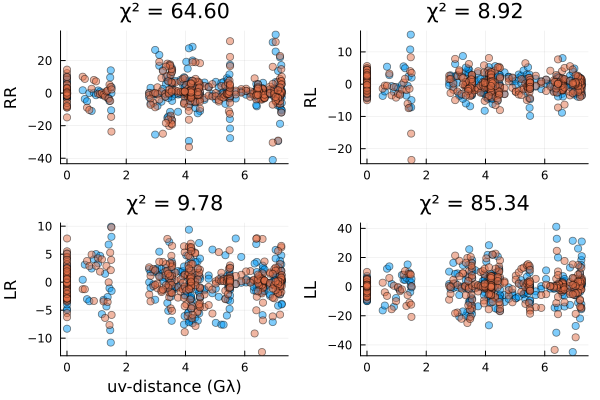

In [27]:
using Plots
residual(vlbimodel(post, xopt), dvis)

In [28]:
imgtrue = Comrade.load(joinpath("Comrade.jl/examples/Data", 
                                "polarized_gaussian.fits"), 
                        StokesIntensityMap)

1024×1024 IntensityMap{StokesParams{Float64},2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-4.8434e-10, 4.8434e-10, 1024) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-4.8434e-10, 4.8434e-10, 1024) ForwardOrdered Regular Points
               …  4.8434e-10
 -4.8434e-10       [6.865449211936038e-65, 4.0845945124867704e-78, 1.0298173817904056e-65, 1.0298173817904056e-66]
 -4.83393e-10      [8.995579232319817e-65, 5.351913973100672e-78, 1.3493368848479725e-65, 1.3493368848479725e-66]
 -4.82446e-10      [1.1780389226722592e-64, 7.008734855509941e-78, 1.7670583840083887e-65, 1.7670583840083887e-66]
 -4.815e-10        [1.5419151619160347e-64, 9.173614157880193e-78, 2.312872742874052e-65, 2.312872742874052e-66]
 -4.80553e-10  …   [2.017119604638023e-64, 1.2000839877760228e-77, 3.0256794069570347e-65, 3.0256794069570347e-66]
 -4.79606e-10      [2.6373827062505476e-64, 1.5691091138726288e-77, 3.9560740593758215e-65, 3.956074059375821e-66]
 -4.78659e-10    

┌ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
└ @ Base loading.jl:1664
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/bread/.julia/packages/Makie/z2T2o/src/scenes.jl:220


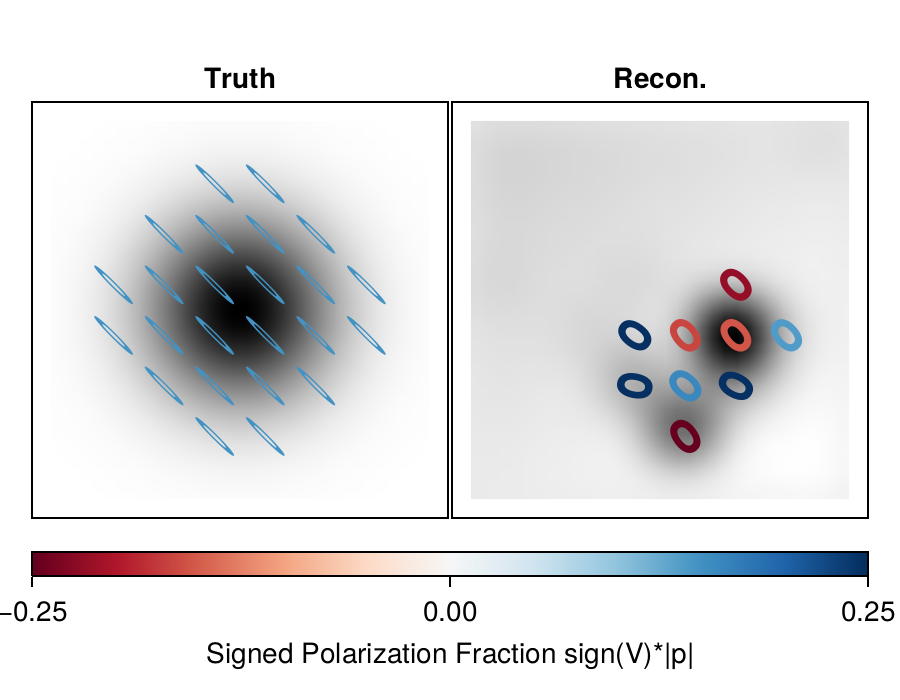

In [29]:
imgtruesub = regrid(imgtrue, imagepixels(fovx, fovy, nx*4, ny*4))
img = intensitymap!(copy(imgtruesub), skymodel(post, xopt))

#Plotting the results gives
import CairoMakie as CM
fig = CM.Figure(;resolution=(450, 350));
polimage(fig[1,1], imgtruesub,
                   axis=(xreversed=true, aspect=1, title="Truth"),
                   nvec = 8,
                   length_norm=1/2, plot_total=true, pcolormap=:RdBu,
                   pcolorrange=(-0.25, 0.25),)
polimage(fig[1,2], img,
                   axis=(xreversed=true, aspect=1, title="Recon.",),
                   nvec = 8,
                   length_norm=1/2, plot_total=true, pcolormap=:RdBu,
                   pcolorrange=(-0.25, 0.25),)
CM.Colorbar(fig[2,:], colormap=:RdBu, vertical=false, colorrange=(-0.25, 0.25), label="Signed Polarization Fraction sign(V)*|p|", flipaxis=false)
CM.colgap!(fig.layout, 3)
CM.rowgap!(fig.layout, 3)
CM.hidedecorations!.(fig.content[1:2])
fig

In [30]:
ftrue = flux(imgtruesub);
@info "Linear polarization true image: $(abs(linearpol(ftrue))/ftrue.I)"
frecon = flux(img);
@info "Linear polarization recon image: $(abs(linearpol(frecon))/frecon.I)"


┌ Info: Linear polarization true image: 0.14999999999999988
└ @ Main In[30]:2
┌ Info: Linear polarization recon image: 0.1527764864117274
└ @ Main In[30]:4


In [31]:
@info "Circular polarization true image: $(ftrue.V/ftrue.I)"
@info "Circular polarization recon image: $(frecon.V/frecon.I)"

┌ Info: Circular polarization true image: 0.014999999999999989
└ @ Main In[31]:1
┌ Info: Circular polarization recon image: 0.015223003308904172
└ @ Main In[31]:2


In [35]:
dR = caltable(trackcache, complex.(xopt.dRx, xopt.dRy))

───────────┬────────────────────────────────────────────────────────────────────
      time │          AA              AP             AZ              JC        ⋯
───────────┼────────────────────────────────────────────────────────────────────
 0.0+0.0im │ 0.01-0.02im  -0.079+0.072im  0.096-0.102im  -0.054+0.052im  0.028 ⋯
───────────┴────────────────────────────────────────────────────────────────────
                                                               3 columns omitted


In [33]:
dL = caltable(trackcache, complex.(xopt.dLx, xopt.dLy))

───────────┬────────────────────────────────────────────────────────────────────
      time │           AA             AP             AZ              JC        ⋯
───────────┼────────────────────────────────────────────────────────────────────
 0.0+0.0im │ 0.03-0.041im  -0.058+0.05im  0.077-0.077im  -0.048+0.085im  0.012 ⋯
───────────┴────────────────────────────────────────────────────────────────────
                                                               3 columns omitted


In [36]:
gphase_ratio = caltable(phasecache, xopt.gpr)

────────┬───────────────────────────────────────────────────────────────
   time │      AA       AP       AZ       JC       LM       PV       SM 
────────┼───────────────────────────────────────────────────────────────
    0.0 │ missing  missing  missing    0.024  missing  missing    0.045
  0.333 │ missing  missing  missing   -0.128  missing  missing   -0.233
  0.667 │ missing  missing  missing    0.206  missing  missing   -0.107
    1.0 │ missing  missing  missing      0.1  missing  missing    0.066
  1.333 │ missing  missing  missing   -0.353  missing  missing   -0.224
  1.667 │ missing  missing  missing   -0.341  missing  missing   -0.085
  9.667 │ missing    0.217  missing  missing  missing    0.251  missing
   10.0 │ missing    0.001  missing  missing  missing    0.196  missing
 10.333 │ missing   -0.077  missing  missing  missing    0.149  missing
 10.667 │ missing    0.041  missing  missing  missing    0.113  missing
   11.0 │ missing   -0.122  missing  missing  missing    0.16

In [37]:
gamp_ratio   = caltable(scancache, exp.(xopt.lgr))

────────┬───────────────────────────────────────────────────────────────
   time │      AA       AP       AZ       JC       LM       PV       SM 
────────┼───────────────────────────────────────────────────────────────
    0.0 │ missing  missing  missing     1.02  missing  missing    1.013
  0.333 │ missing  missing  missing    1.013  missing  missing    1.005
  0.667 │ missing  missing  missing    1.013  missing  missing    1.009
    1.0 │ missing  missing  missing    1.017  missing  missing    1.011
  1.333 │ missing  missing  missing    1.005  missing  missing    0.995
  1.667 │ missing  missing  missing    1.008  missing  missing    1.002
  9.667 │   1.042    1.014  missing  missing  missing    1.272  missing
   10.0 │    1.04    0.998  missing  missing  missing     1.24  missing
 10.333 │   1.037    1.005  missing  missing  missing    1.177  missing
 10.667 │   1.032    1.003  missing  missing  missing    1.155  missing
   11.0 │    1.03    0.993  missing  missing  missing    1.11

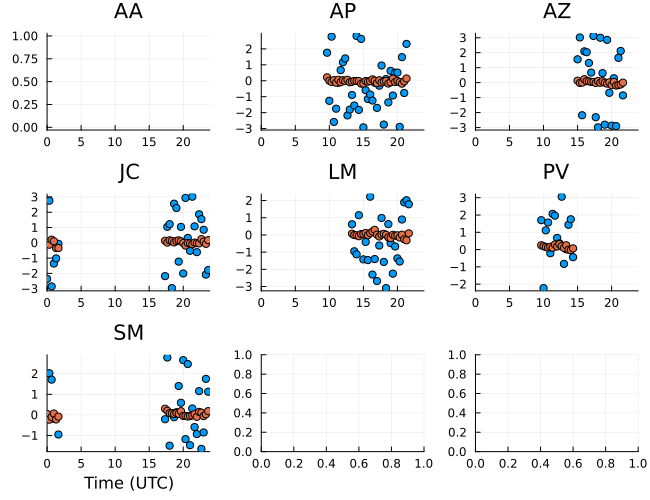

In [38]:
gphase_prod = caltable(phasecache, xopt.gpp)
plot(gphase_prod, layout=(3,3), size=(650,500))
plot!(gphase_ratio, layout=(3,3), size=(650,500))

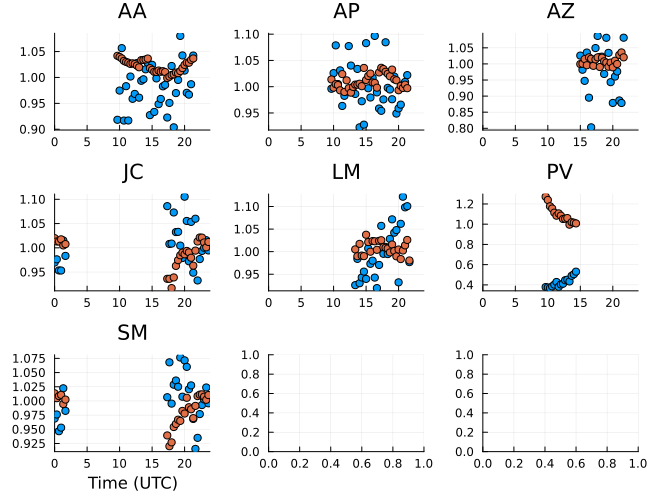

In [39]:
gamp_prod = caltable(scancache, exp.(xopt.lgp))
plot(gamp_prod, layout=(3,3), size=(650,500))
plot!(gamp_ratio, layout=(3,3), size=(650,500))